In [1]:
# For Sam

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

loading the dataset

In [3]:
dataset = pd.read_csv("Train.csv")
finaltest = pd.read_csv("Test.csv")
riders = pd.read_csv('Riders.csv')
sample = pd.read_csv('SampleSubmission.csv')

Checking it out

In [4]:
dataset.head(2)

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993


In [5]:
riders.head(2)

,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Rider_Id_396,2946,2298,14.0,1159
1,Rider_Id_479,360,951,13.5,176


In [6]:
finaltest.head(2)

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,...,3,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,...,5,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868


In [7]:
set(dataset.columns) - set(finaltest.columns)

{'Arrival at Destination - Day of Month',
 'Arrival at Destination - Time',
 'Arrival at Destination - Weekday (Mo = 1)',
 'Time from Pickup to Arrival'}

we must drop the above before moving on

are the columns in the final that are not on training?

In [8]:
set(finaltest.columns) - set(dataset.columns)

set()

The placement time of the order is irrelevant to the target. The main concern of the problem statement is the period between pickup and arrival. When the order was placed, has no bearing whatsoever in effect to that period. So, we are going to drop everything concerning placement. 

Furthermore, 'Confirmation' columns, with the same argument, must be dropped.

In [9]:
placement = [col for col in dataset.columns if ((col[:len('Placement')] == 'Placement') or (col[:len('Confirmation')] == 'Confirmation')) ]

In [10]:
placement

['Placement - Day of Month',
 'Placement - Weekday (Mo = 1)',
 'Placement - Time',
 'Confirmation - Day of Month',
 'Confirmation - Weekday (Mo = 1)',
 'Confirmation - Time']

In [11]:
xdata = dataset.drop(columns=['Time from Pickup to Arrival', 'User Id', 'Order No', 
'Arrival at Destination - Day of Month',
'Arrival at Destination - Time',
'Arrival at Destination - Weekday (Mo = 1)'] + placement)
X = xdata.copy() # I want to run this column everytime I want to restart after changes
X = X.merge(riders, how='left', on=['Rider Id']).drop(columns=['Rider Id'])

f_testx = finaltest.merge(riders, how='left', on=['Rider Id']).drop(columns=['User Id', 'Order No', 'Rider Id'] + placement)

In [12]:
y = dataset['Time from Pickup to Arrival'] # The target

Confirm columns if columns on train are those on test

In [13]:
set(f_testx.columns) == set(X.columns)

True

We Split

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Now things are about to get ugly

In [15]:
### START FUNCTION
def cleaner(input_df, nullthreshold=0.9, correlation_thresh=0.95, day_of_month_cols=[], day_of_week_cols=[]):
    input_dfc = input_df.copy()
    

    #########################################################################################
    # The Code below drops columns that have null values exceeding threshold and Columns that have ONLY one value
    for col in input_df.columns:
        if (sum(input_df[col].isnull())/len(input_df[col]) > nullthreshold) or (len(input_df[col].unique()) == 1):
            input_dfc.drop(columns=[col], inplace=True) 
            
    #########################################################################################

    #########################################################################################
    #This code converts time given by am and pm into seconds then applies cosine and sine
    def time_to_seconds(input_df):
        input_dfc = input_df.copy()

        from datetime import datetime

        for time_col in [col for col in input_df.columns if 'Time' in [col[-4:]]]:

            input_dfc[time_col + '_sin(seconds)'] = \
            input_df[time_col].apply(lambda time: np.sin(
                (datetime.strptime(time, '%I:%M:%S %p') - datetime(1900,1,1)).total_seconds() \
                * (2.*np.pi/86400) )) # there are 86400 seconds in a day

            input_dfc[time_col + '_cos(seconds)'] = \
            input_df[time_col].apply(lambda time: np.cos(
                (datetime.strptime(time, '%I:%M:%S %p') - datetime(1900,1,1)).total_seconds() \
                * (2.*np.pi/86400) ))

            input_dfc.drop(columns=[time_col], inplace=True)

        return input_dfc

    input_dfc2 = time_to_seconds(input_dfc)
    #########################################################################################
    
    #########################################################################################
    # This code encodes ['Platform Type', 'Personal or Business']
    
    def one_encoder(input_df, columns):
    
        return pd.get_dummies(input_df, drop_first=True, columns=columns, dtype=float)

    
    input_dfc2 = one_encoder(input_dfc2, ['Platform Type', 'Personal or Business'])
    #########################################################################################
    def cyclic_days(input_df, month_days_cols, weekdays_cols):
        input_dfc = input_df.copy()


        for mday_col in month_days_cols:
            if mday_col in input_dfc.columns:

                input_dfc[mday_col + '_sin(day)'] = input_df[mday_col].apply(lambda day: np.sin(\
                day * (2.*np.pi/31))\
                    )

                input_dfc[mday_col + '_cos(day)'] = input_df[mday_col].apply(lambda day: np.cos(\
                day * (2.*np.pi/31))\
                    )

                input_dfc.drop(mday_col, inplace=True, axis=1)


        for wday_col in weekdays_cols:
            if wday_col in input_dfc.columns:

                input_dfc[wday_col + '_sin(day)'] = input_df[wday_col].apply(lambda day: np.sin(\
                day * (2.*np.pi/7))\
                    )

                input_dfc[wday_col + '_cos(day)'] = input_df[wday_col].apply(lambda day: np.cos(\
                day * (2.*np.pi/7))\
                    )

                input_dfc.drop(wday_col, inplace=True, axis=1)
            else:
                continue

        return input_dfc
    
    input_dfc2 = cyclic_days(input_dfc2, day_of_month_cols, day_of_week_cols)     
    #########################################################################################
    # This code will remove one of a pair of variables that are 95% correlated
    def correlation_drop(df, thresh):
        while True:
            corr_matrix = df.corr(method = "spearman").abs()
            upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
            to_drop = [column for column in upper.columns if any(upper[column] > thresh)]
            if len(to_drop) == 0:
                break
            else:
                df = df.drop(to_drop, axis = 1)
            
        return df
    
    input_dfc2 = correlation_drop(input_dfc2, correlation_thresh)
    #########################################################################################

    print(f"Total of {len([x for x in input_df.columns if x not in input_dfc2])} original columns dropped \n")  
    print(f"Total of {len([x for x in input_dfc2.columns if x not in input_df])} new CLEAN columns formed \n")
    print(f"Dataframe now has {len(input_dfc2.columns)} from {len(input_df.columns)} input columns")
    #print([x for x in input_df.columns if x not in input_dfc2])

    return input_dfc2

### END FUNCTION

Now we apply our ultimate cleaner

In [16]:
day_of_month_cols = [x for x in X.columns if x[-5:] == 'Month']
day_of_week_cols = [x for x in X.columns if x[-(len('(Mo = 1)')):] == '(Mo = 1)']
X_train = cleaner(X_train, day_of_month_cols=day_of_month_cols, day_of_week_cols=day_of_week_cols)

Total of 10 original columns dropped 

Total of 10 new CLEAN columns formed 

Dataframe now has 20 from 20 input columns


In [17]:
X_test = cleaner(X_test, day_of_month_cols=day_of_month_cols, day_of_week_cols=day_of_week_cols)

Total of 10 original columns dropped 

Total of 10 new CLEAN columns formed 

Dataframe now has 20 from 20 input columns


In [18]:
X1 = cleaner(X, day_of_month_cols=day_of_month_cols, day_of_week_cols=day_of_week_cols) # When we want to create a cross validation model

Total of 10 original columns dropped 

Total of 10 new CLEAN columns formed 

Dataframe now has 20 from 20 input columns


We must also apply it on our finial test: 

In [19]:
F_test = cleaner(f_testx, day_of_month_cols=day_of_month_cols, day_of_week_cols=day_of_week_cols)

Total of 10 original columns dropped 

Total of 10 new CLEAN columns formed 

Dataframe now has 20 from 20 input columns


In [20]:
X1.head(2)

,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Arrival at Pickup - Time_sin(seconds),Arrival at Pickup - Time_cos(seconds),Platform Type_2,Platform Type_3,Platform Type_4,Personal or Business_Personal,Arrival at Pickup - Day of Month_sin(day),Arrival at Pickup - Day of Month_cos(day),Arrival at Pickup - Weekday (Mo = 1)_sin(day),Arrival at Pickup - Weekday (Mo = 1)_cos(day)
0,4,20.4,-1.317755,36.830370,-1.300406,36.829741,1637,1309,13.8,549,0.481817,-0.876272,0.0,1.0,0.0,0.0,0.968077,-0.250653,-0.974928,-0.222521
1,16,26.4,-1.351453,36.899315,-1.295004,36.814358,396,339,13.6,69,0.085562,-0.996333,0.0,1.0,0.0,1.0,0.651372,-0.758758,-0.974928,-0.222521


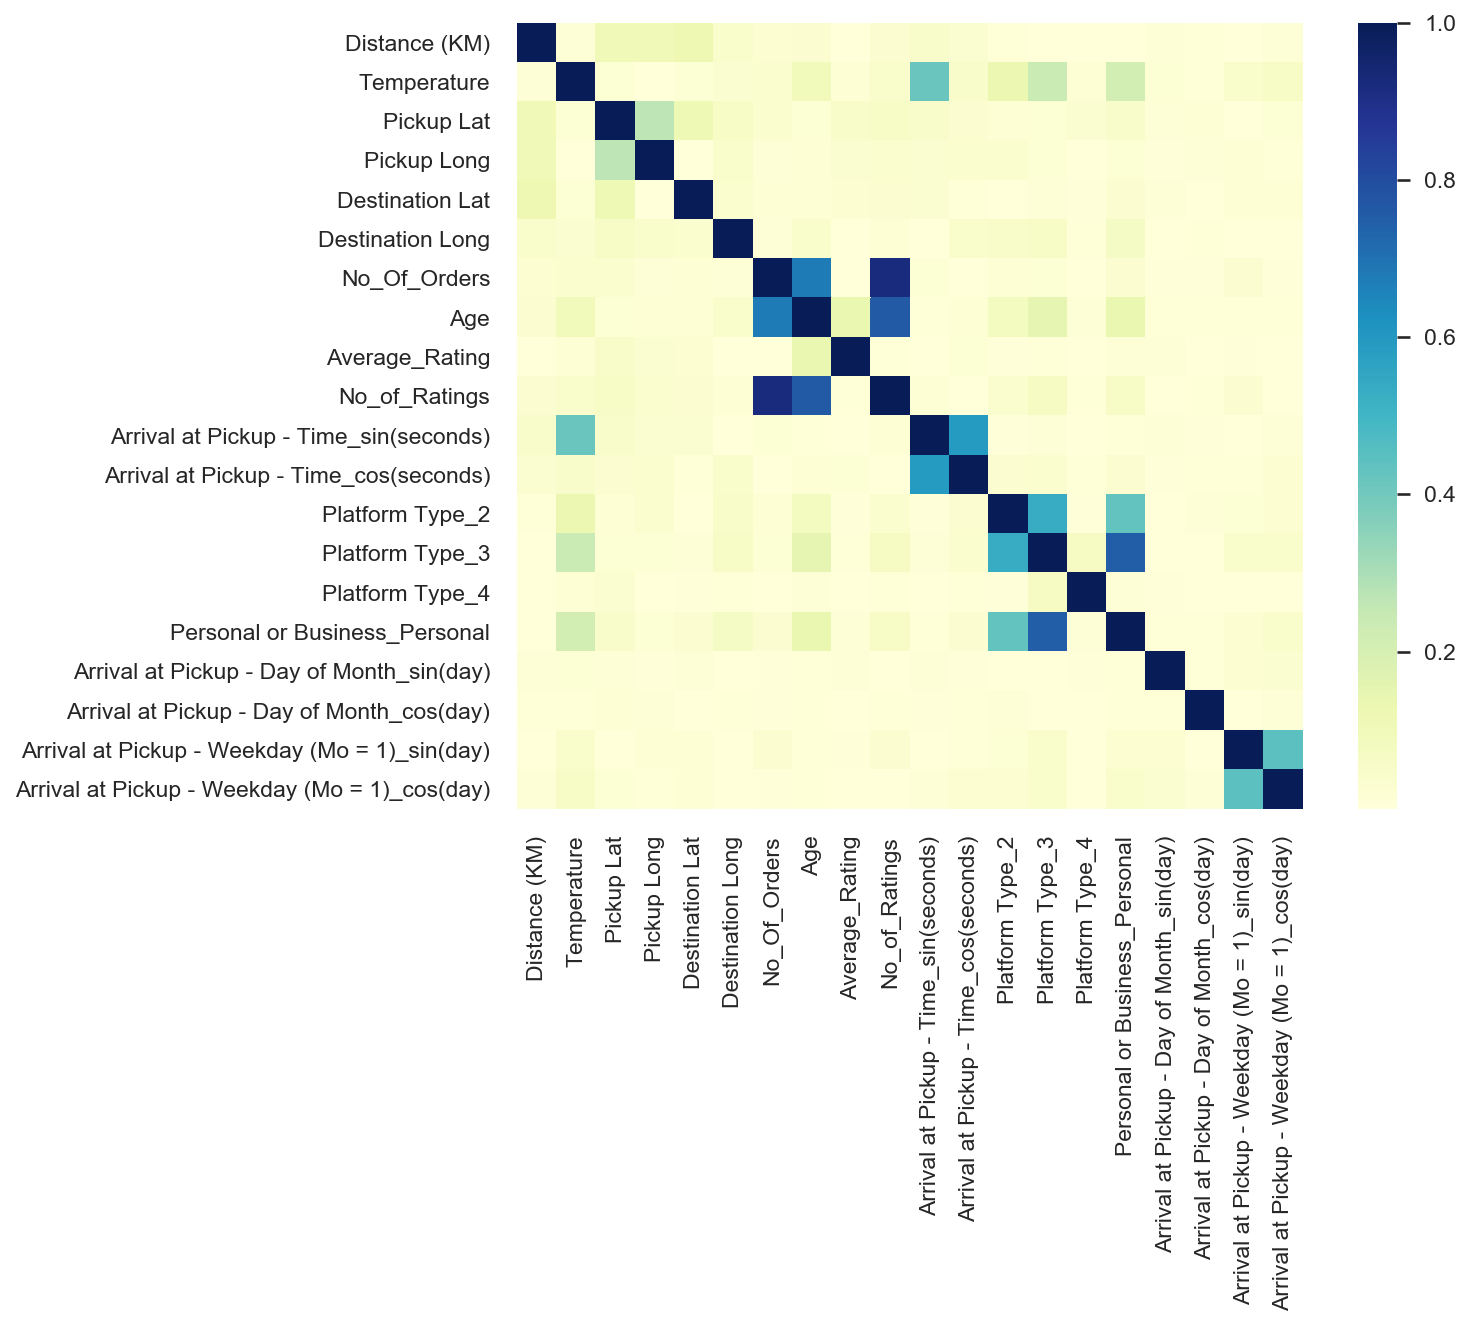

In [21]:
corr_matrix = X_train.corr(method = "spearman").abs()
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()


In [22]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
polinomial_features = PolynomialFeatures(2)
# Construct the pipeline with a standard scaler and a small neural network
models = [Lasso(alpha=0.1), Ridge(), LinearRegression()]
for mod in models:
    estimators = []
    estimators.append(('imputer', SimpleImputer(strategy='median')))
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('plf', polinomial_features))
    estimators.append(('mod', mod))
    model = Pipeline(estimators)

    # To begin, let's use only these two features to predict 'cnt' (bicycle count)

    # We'll use 5-fold cross validation. That is, a random 80% of the data will be used
    # to train the model, and the prediction score will be computed on the remaining 20%.
    # This process is repeated five times such that the training sets in each "fold"
    # are mutually orthogonal.
    from sklearn.model_selection import KFold
    from sklearn.model_selection import cross_val_score
    kfold = KFold(n_splits=5)

    results = cross_val_score(model, X1, y, cv=kfold, scoring='neg_mean_squared_error')
    print(mod)
    print ('CV Scoring Result: mean=',np.sqrt(abs(np.mean(results))),'std=',np.std(results))
    print('\n')

Lasso(alpha=0.1)
CV Scoring Result: mean= 783.5307852012073 std= 32124.69428307536


Ridge()
CV Scoring Result: mean= 784.2178955952949 std= 32369.363197718914


LinearRegression()
CV Scoring Result: mean= 1392099454.9155166 std= 3.855475629831994e+18




In [23]:
print('counts')
p1 = 0
for i in range(len(X1['Platform Type_2'])):
    if (X1['Platform Type_2'][i] == X1['Platform Type_3'][i]) == (X1['Platform Type_4'][i] == 0):
        p1 += 1

p2 = sum(X1['Platform Type_2'] == 1)
p3 = sum(X1['Platform Type_3'] == 1)
p4 = sum(X1['Platform Type_4'] == 1)

print('Platform Type_1: ', p1)
print('Platform Type_2: ', sum(X1['Platform Type_2'] == 1))
print('Platform Type_3: ', sum(X1['Platform Type_3'] == 1))
print('Platform Type_4: ', sum(X1['Platform Type_4'] == 1))


print('\n')

print('propotions')
print('total = ', sum([p1,p2,p3,p4]))
for value in [p1,p2,p3,p4]:
    print(round(value * 100/sum([p1,p2,p3,p4]), 2))
     

counts
Platform Type_1:  2147
Platform Type_2:  980
Platform Type_3:  18054
Platform Type_4:  20


propotions
total =  21201
10.13
4.62
85.16
0.09


In [24]:
print('counts')

personal = sum(X1['Personal or Business_Personal'] == 1)
business = sum(X1['Personal or Business_Personal'] != 1)
print('personal: ', personal, '\nbusiness: ', business, '\n')
print('propotions')
for value in [personal, business]:
    print(round(value * 100/sum([personal, business]), 2))

counts
personal:  3817 
business:  17384 

propotions
18.0
82.0


In [25]:
print('counts')
p1 = 0
for i in range(len(F_test['Platform Type_2'])):
    if (F_test['Platform Type_2'][i] == F_test['Platform Type_3'][i]) == (F_test['Platform Type_4'][i] == 0):
        p1 += 1

p2 = sum(F_test['Platform Type_2'] == 1)
p3 = sum(F_test['Platform Type_3'] == 1)
p4 = sum(F_test['Platform Type_4'] == 1)

print('Platform Type_1: ', p1)
print('Platform Type_2: ', sum(F_test['Platform Type_2'] == 1))
print('Platform Type_3: ', sum(F_test['Platform Type_3'] == 1))
print('Platform Type_4: ', sum(F_test['Platform Type_4'] == 1))


print('\n')

print('propotions')
print('total = ', sum([p1,p2,p3,p4]))
for value in [p1,p2,p3,p4]:
    print(round(value * 100/sum([p1,p2,p3,p4]), 2))
     

counts
Platform Type_1:  711
Platform Type_2:  336
Platform Type_3:  6015
Platform Type_4:  6


propotions
total =  7068
10.06
4.75
85.1
0.08


In [26]:
data = pd.concat([X1, y], axis=1)
data.columns

Index(['Distance (KM)', 'Temperature', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'No_Of_Orders', 'Age',
       'Average_Rating', 'No_of_Ratings',
       'Arrival at Pickup - Time_sin(seconds)',
       'Arrival at Pickup - Time_cos(seconds)', 'Platform Type_2',
       'Platform Type_3', 'Platform Type_4', 'Personal or Business_Personal',
       'Arrival at Pickup - Day of Month_sin(day)',
       'Arrival at Pickup - Day of Month_cos(day)',
       'Arrival at Pickup - Weekday (Mo = 1)_sin(day)',
       'Arrival at Pickup - Weekday (Mo = 1)_cos(day)',
       'Time from Pickup to Arrival'],
      dtype='object')

In [27]:
data[['Temperature']].head(10)

,Temperature
0,20.4
1,26.4
2,NaN
3,19.2
4,15.4
5,27.2
6,20.3
7,28.7
8,NaN
9,24.6


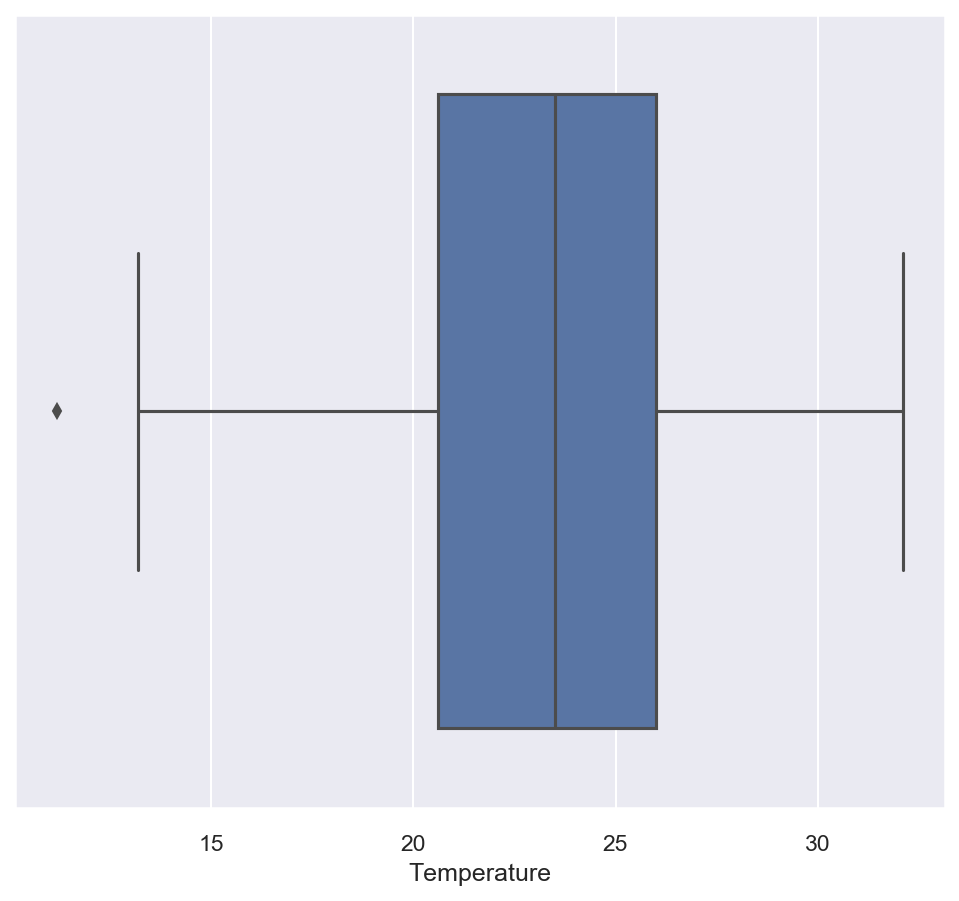

In [28]:
sns.boxplot(X1['Temperature'])

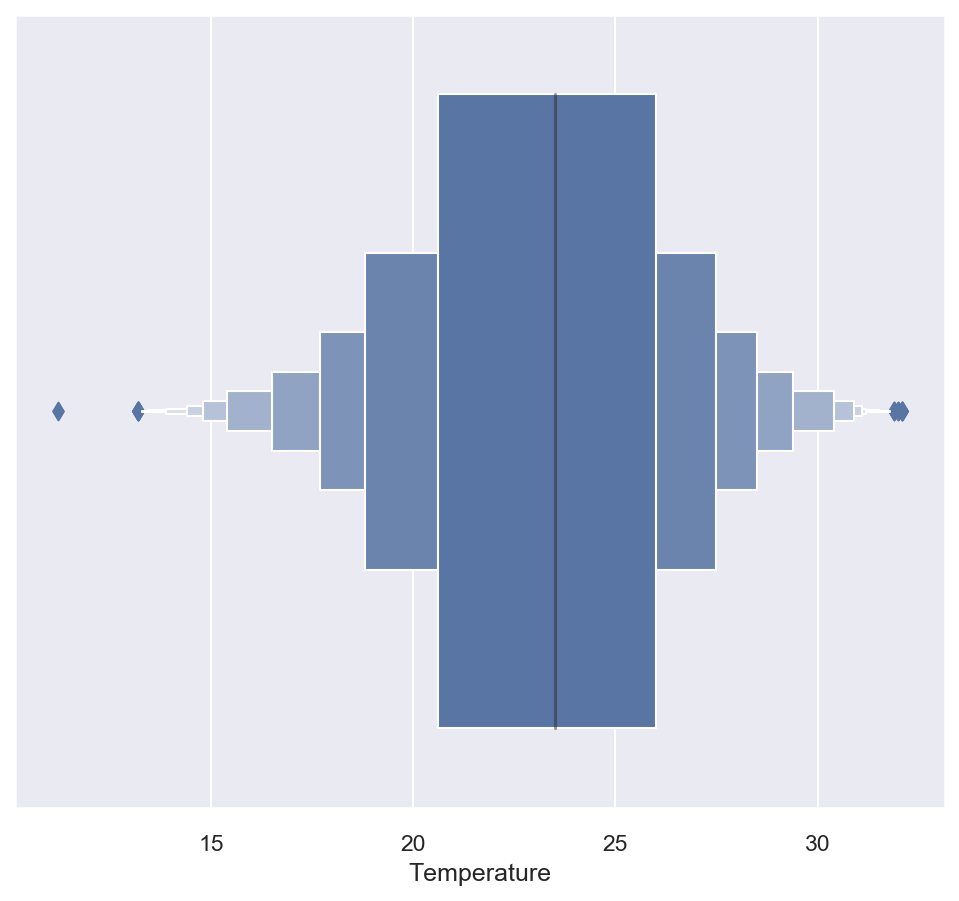

In [29]:
sns.boxenplot(X1['Temperature'])

In [30]:
print('mean: ', data['Temperature'].mean())
print('median: ', data['Temperature'].median())

mean:  23.25888921888938
median:  23.5


In [31]:
data['Temperature'].fillna(data['Temperature'].median(), inplace=True)

In [32]:
corrs = data.corr()['Time from Pickup to Arrival'].sort_values(ascending=False)

from scipy.stats import pearsonr

# Build a dictionary of correlation coefficients and p-values
dict_cp = {}

column_titles = [col for col in corrs.index if col!= 'Time from Pickup to Arrival']
for col in column_titles:
    p_val = round(pearsonr(data[col], data['Time from Pickup to Arrival'])[1],6)
    dict_cp[col] = {'Correlation_Coefficient':corrs[col],
                    'P_Value':p_val}

df_cp = pd.DataFrame(dict_cp).T
df_cp_sorted = df_cp.sort_values('P_Value')
df_cp_sorted 

,Correlation_Coefficient,P_Value
Distance (KM),0.580608,0.000000
Average_Rating,-0.042559,0.000000
No_Of_Orders,-0.041608,0.000000
Pickup Lat,-0.053823,0.000000
Destination Lat,-0.061872,0.000000
Pickup Long,0.060285,0.000000
Destination Long,0.070425,0.000000
Arrival at Pickup - Weekday (Mo = 1)_cos(day),-0.025897,0.000162
Arrival at Pickup - Time_sin(seconds),-0.023330,0.000681
Arrival at Pickup - Day of Month_sin(day),0.021230,0.001992


In [33]:
to_drop = df_cp_sorted[df_cp_sorted['P_Value'] > 0.1].index
X_train2 = X_train.drop(columns=to_drop)
X_test2 = X_test.drop(columns=to_drop)
F_test2 = F_test.drop(columns=to_drop)
X2 = X1.drop(columns=to_drop)

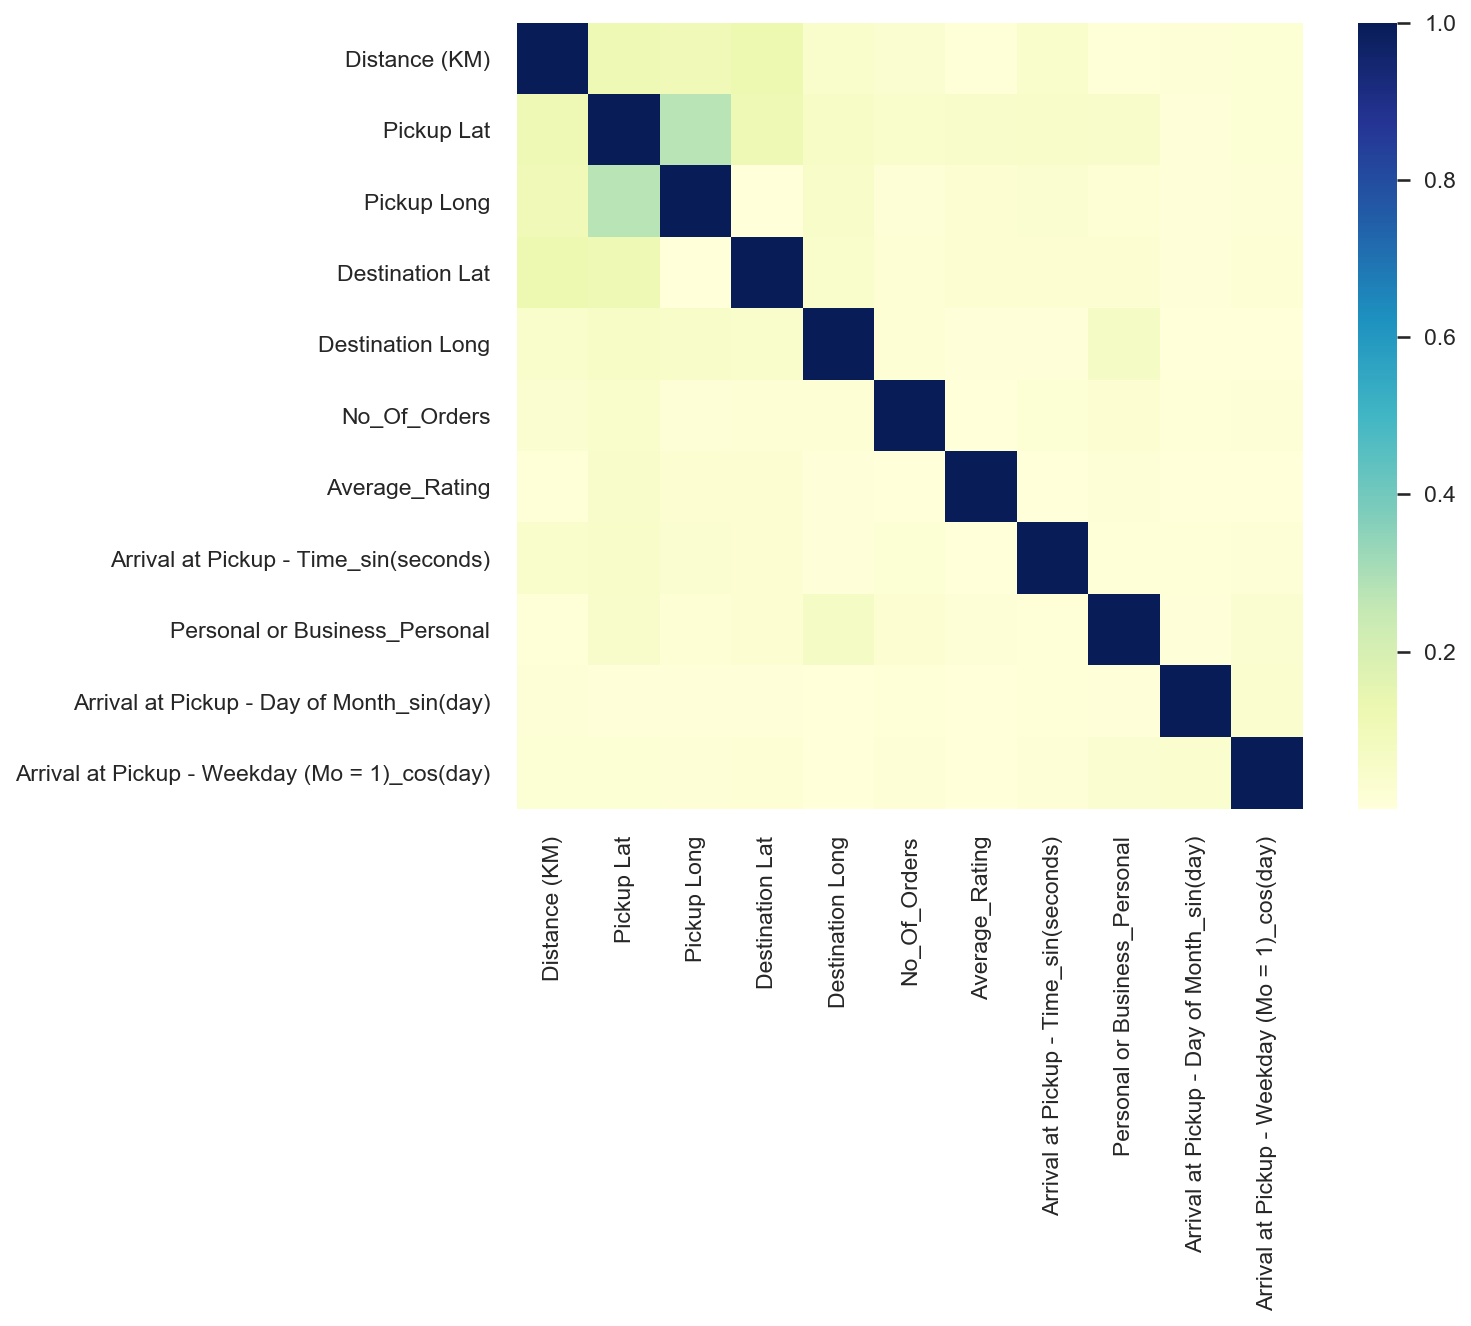

In [34]:
corr_matrix = X_train2.corr(method = "spearman").abs()
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()


In [35]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
polinomial_features = PolynomialFeatures(2)
# Construct the pipeline with a standard scaler and a small neural network
models = [Lasso(alpha=0.1), Ridge(), LinearRegression()]
for mod in models:
    estimators = []
    estimators.append(('imputer', SimpleImputer(strategy='median')))
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('plf', polinomial_features))
    estimators.append(('mod', mod))
    model = Pipeline(estimators)

    # To begin, let's use only these two features to predict 'cnt' (bicycle count)

    # We'll use 5-fold cross validation. That is, a random 80% of the data will be used
    # to train the model, and the prediction score will be computed on the remaining 20%.
    # This process is repeated five times such that the training sets in each "fold"
    # are mutually orthogonal.
    from sklearn.model_selection import KFold
    from sklearn.model_selection import cross_val_score
    kfold = KFold(n_splits=5)

    results = cross_val_score(model, X2, y, cv=kfold, scoring='neg_mean_squared_error')
    print(mod)
    print ('CV Scoring Result: mean=',np.sqrt(abs(np.mean(results))),'std=',np.std(results))
    print('\n')

Lasso(alpha=0.1)
CV Scoring Result: mean= 785.5800626271457 std= 32512.784016909787


Ridge()
CV Scoring Result: mean= 785.609033100734 std= 32517.219514157918


LinearRegression()
CV Scoring Result: mean= 785.6088725649045 std= 32518.07093663242




Our data is ready

We will standardize the columns which have a max absolute value that is greater than 1

In [36]:
X1.head(10)

,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Arrival at Pickup - Time_sin(seconds),Arrival at Pickup - Time_cos(seconds),Platform Type_2,Platform Type_3,Platform Type_4,Personal or Business_Personal,Arrival at Pickup - Day of Month_sin(day),Arrival at Pickup - Day of Month_cos(day),Arrival at Pickup - Weekday (Mo = 1)_sin(day),Arrival at Pickup - Weekday (Mo = 1)_cos(day)
0,4,20.4,-1.317755,36.830370,-1.300406,36.829741,1637,1309,13.8,549,0.481817,-0.876272,0.0,1.0,0.0,0.0,0.968077,-0.250653,-0.974928,-0.222521
1,16,26.4,-1.351453,36.899315,-1.295004,36.814358,396,339,13.6,69,0.085562,-0.996333,0.0,1.0,0.0,1.0,0.651372,-0.758758,-0.974928,-0.222521
2,3,NaN,-1.308284,36.843419,-1.300921,36.828195,1023,242,12.5,114,-0.214593,-0.976703,0.0,1.0,0.0,0.0,-0.201299,0.979530,0.974928,-0.222521
3,9,19.2,-1.281301,36.832396,-1.257147,36.795063,886,283,14.5,113,0.580940,-0.813947,0.0,1.0,0.0,0.0,0.101168,-0.994869,-0.974928,-0.222521
4,9,15.4,-1.266597,36.792118,-1.295041,36.809817,2311,872,14.1,533,0.485255,-0.874373,0.0,0.0,0.0,1.0,0.485302,-0.874347,0.781831,0.623490
5,9,27.2,-1.302583,36.767081,-1.257309,36.806008,3288,1204,14.2,1056,-0.770513,-0.637424,0.0,1.0,0.0,0.0,0.299363,-0.954139,-0.974928,-0.222521
6,5,20.3,-1.279395,36.825364,-1.276574,36.851365,288,556,13.7,27,0.525472,-0.850811,0.0,1.0,0.0,0.0,0.968077,-0.250653,-0.974928,-0.222521
7,3,28.7,-1.252796,36.800313,-1.255189,36.782203,4036,2119,14.4,700,-0.579103,-0.815254,0.0,1.0,0.0,0.0,0.790776,-0.612106,0.781831,0.623490
8,9,NaN,-1.255189,36.782203,-1.300255,36.825657,162,237,15.0,14,-0.058000,-0.998317,0.0,1.0,0.0,0.0,-0.201299,0.979530,0.974928,-0.222521
9,14,24.6,-1.225322,36.808550,-1.215601,36.891686,1062,573,13.2,100,-0.992905,-0.118909,0.0,1.0,0.0,0.0,-0.998717,-0.050649,-0.974928,-0.222521


In [37]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X1)
X_normalize = pd.DataFrame(X_scaled, columns=X1.columns)

In [38]:
X_normalize.head(3)

,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Arrival at Pickup - Time_sin(seconds),Arrival at Pickup - Time_cos(seconds),Platform Type_2,Platform Type_3,Platform Type_4,Personal or Business_Personal,Arrival at Pickup - Day of Month_sin(day),Arrival at Pickup - Day of Month_cos(day),Arrival at Pickup - Weekday (Mo = 1)_sin(day),Arrival at Pickup - Weekday (Mo = 1)_cos(day)
0,0.062500,0.440191,0.414064,0.523818,0.324671,0.544015,0.167624,0.330698,0.907895,0.238903,0.756342,0.061908,0.0,1.0,0.0,0.0,0.984661,0.373065,0.0,0.356896
1,0.312500,0.727273,0.298315,0.728144,0.338174,0.506513,0.040394,0.066249,0.894737,0.030026,0.554087,0.001835,0.0,1.0,0.0,1.0,0.826105,0.118359,0.0,0.356896
2,0.041667,NaN,0.446594,0.562490,0.323384,0.540246,0.104675,0.039804,0.822368,0.049608,0.400883,0.011656,0.0,1.0,0.0,0.0,0.399221,0.989739,1.0,0.356896


In [39]:
from sklearn.feature_selection import VarianceThreshold

# Create VarianceThreshold object
selector = VarianceThreshold(threshold=0.03)

# Use the object to apply the threshold on data
selector.fit(X_normalize)

VarianceThreshold(threshold=0.03)

In [40]:
# Get column variances
column_variances = selector.variances_

vars_dict = {}
vars_dict = [{"Variable_Name": c_name, "Variance": c_var}
             for c_name, c_var in zip(X_normalize.columns, column_variances)]
df_vars = pd.DataFrame(vars_dict)
df_vars.sort_values(by='Variance', ascending=False)

,Variable_Name,Variance
18,Arrival at Pickup - Weekday (Mo = 1)_sin(day),0.148688
15,Personal or Business_Personal,0.147625
16,Arrival at Pickup - Day of Month_sin(day),0.127528
13,Platform Type_3,0.126403
17,Arrival at Pickup - Day of Month_cos(day),0.122843
19,Arrival at Pickup - Weekday (Mo = 1)_cos(day),0.098207
10,Arrival at Pickup - Time_sin(seconds),0.075766
12,Platform Type_2,0.044088
7,Age,0.031079
9,No_of_Ratings,0.030733


In [41]:
lowvar = np.array(df_vars.loc[range(8)]['Variable_Name'])
lowvar

array(['Distance (KM)', 'Temperature', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'No_Of_Orders', 'Age'],
      dtype=object)

In [42]:
# Select new columns
X_new = X_normalize[X_normalize.columns[selector.get_support(indices=True)]]

# Save variable names for later
X_var_names = X_new.columns

# View first few entries
X_new.head()

,Age,No_of_Ratings,Arrival at Pickup - Time_sin(seconds),Platform Type_2,Platform Type_3,Personal or Business_Personal,Arrival at Pickup - Day of Month_sin(day),Arrival at Pickup - Day of Month_cos(day),Arrival at Pickup - Weekday (Mo = 1)_sin(day),Arrival at Pickup - Weekday (Mo = 1)_cos(day)
0,0.330698,0.238903,0.756342,0.0,1.0,0.0,0.984661,0.373065,0.000000,0.356896
1,0.066249,0.030026,0.554087,0.0,1.0,1.0,0.826105,0.118359,0.000000,0.356896
2,0.039804,0.049608,0.400883,0.0,1.0,0.0,0.399221,0.989739,1.000000,0.356896
3,0.050981,0.049173,0.806935,0.0,1.0,0.0,0.550649,0.000000,0.000000,0.356896
4,0.211559,0.231941,0.758096,0.0,0.0,1.0,0.742963,0.060416,0.900969,0.801938


In [43]:
selector.transform(X_normalize)

array([[3.30697928e-01, 2.38903394e-01, 7.56341573e-01, ...,
        3.73065435e-01, 0.00000000e+00, 3.56895868e-01],
       [6.62486369e-02, 3.00261097e-02, 5.54086840e-01, ...,
        1.18359232e-01, 0.00000000e+00, 3.56895868e-01],
       [3.98037077e-02, 4.96083551e-02, 4.00883208e-01, ...,
        9.89738647e-01, 1.00000000e+00, 3.56895868e-01],
       ...,
       [1.02780807e-01, 1.26196693e-02, 4.28462686e-03, ...,
        5.74622652e-01, 2.77479066e-01, 0.00000000e+00],
       [4.70283533e-01, 4.79112272e-01, 8.05028607e-01, ...,
        8.44083481e-01, 7.22520934e-01, 5.55111512e-17],
       [5.17993457e-02, 3.04612707e-02, 2.09530286e-01, ...,
        7.63876268e-01, 1.00000000e+00, 3.56895868e-01]])

In [128]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
polinomial_features = PolynomialFeatures(1)
# Construct the pipeline with a standard scaler and a small neural network
models = [Lasso(alpha=0.1), LinearRegression(), RandomForestRegressor(random_state=42)]
for mod in models:
    estimators = []
    estimators.append(('imputer', SimpleImputer(strategy='median')))
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('plf', polinomial_features))
    estimators.append(('mod', mod))
    model = Pipeline(estimators)

    # To begin, let's use only these two features to predict 'cnt' (bicycle count)

    # We'll use 5-fold cross validation. That is, a random 80% of the data will be used
    # to train the model, and the prediction score will be computed on the remaining 20%.
    # This process is repeated five times such that the training sets in each "fold"
    # are mutually orthogonal.
    from sklearn.model_selection import KFold
    from sklearn.model_selection import cross_val_score
    kfold = KFold(n_splits=5)

    results = cross_val_score(model, X1.drop(columns=['No_Of_Orders', 'Age', 'Temperature']), y, cv=kfold, scoring='neg_mean_squared_error')
    print(mod)
    print ('CV Scoring Result: mean=',np.sqrt(abs(np.mean(results))),'std=',np.std(results))
    print('\n')

Lasso(alpha=0.1)
CV Scoring Result: mean= 799.1358799852896 std= 33914.04060972751


LinearRegression()
CV Scoring Result: mean= 799.1397340364857 std= 33913.447858325664


RandomForestRegressor(random_state=42)
CV Scoring Result: mean= 777.2693928449283 std= 33382.79200354074




In [45]:
estimators = []
# estimators.append(('imputer', SimpleImputer(strategy='median')))
estimators.append(('standardize', StandardScaler()))
estimators.append(('plf', polinomial_features))
estimators.append(('mod', RandomForestRegressor()))
model = Pipeline(estimators)

In [46]:
v1 = sample.copy()
model.fit(X1, y)
y_pred = model.predict(F_test)
v1['Order_No'] = finaltest['Order No']
v1['Time from Pickup to Arrival'] = y_pred

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [47]:
v1.to_csv('lasso.csv', index=False)

In [48]:


# Normalize data




In [49]:
# for x in [col for col in data.columns if col!= 'Time from Pickup to Arrival']:
#     plt.plot(x, 'Time from Pickup to Arrival', data=data)
# plt.show()   

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, Normalizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

In [51]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [52]:
def sklearn_kfold_split(data,K):
    kf = KFold(n_splits=K, shuffle=False)

    
    return [(datatr, datate) for datatr, datate in kf.split(data)]

In [53]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data.iloc[:,:-1])
X_normalize = pd.DataFrame(X_scaled, columns=data.iloc[:,:-1].columns)

In [54]:
X_normalize

,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Arrival at Pickup - Time_sin(seconds),Arrival at Pickup - Time_cos(seconds),Platform Type_2,Platform Type_3,Platform Type_4,Personal or Business_Personal,Arrival at Pickup - Day of Month_sin(day),Arrival at Pickup - Day of Month_cos(day),Arrival at Pickup - Weekday (Mo = 1)_sin(day),Arrival at Pickup - Weekday (Mo = 1)_cos(day)
0,0.062500,0.440191,0.414064,0.523818,0.324671,0.544015,0.167624,0.330698,0.907895,0.238903,0.756342,0.061908,0.0,1.0,0.0,0.0,0.984661,0.373065,0.000000,3.568959e-01
1,0.312500,0.727273,0.298315,0.728144,0.338174,0.506513,0.040394,0.066249,0.894737,0.030026,0.554087,0.001835,0.0,1.0,0.0,1.0,0.826105,0.118359,0.000000,3.568959e-01
2,0.041667,0.588517,0.446594,0.562490,0.323384,0.540246,0.104675,0.039804,0.822368,0.049608,0.400883,0.011656,0.0,1.0,0.0,0.0,0.399221,0.989739,1.000000,3.568959e-01
3,0.166667,0.382775,0.539277,0.529822,0.432799,0.459474,0.090629,0.050981,0.953947,0.049173,0.806935,0.093092,0.0,1.0,0.0,0.0,0.550649,0.000000,0.000000,3.568959e-01
4,0.166667,0.200957,0.589783,0.410453,0.338082,0.495443,0.236723,0.211559,0.927632,0.231941,0.758096,0.062858,0.0,0.0,0.0,1.0,0.742963,0.060416,0.900969,8.019377e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21196,0.041667,0.832536,0.617891,0.448038,0.387464,0.478097,0.129998,0.073882,0.947368,0.057006,0.069706,0.247943,0.0,1.0,0.0,1.0,0.104104,0.191874,0.722521,5.551115e-17
21197,0.125000,0.708134,0.450514,0.507929,0.246653,0.588471,0.104675,0.039804,0.822368,0.049608,0.725991,0.046818,0.0,1.0,0.0,0.0,0.742963,0.060416,0.099031,8.019377e-01
21198,0.395833,0.861244,0.523075,0.722865,0.429632,0.483211,0.031987,0.102781,0.907895,0.012620,0.004285,0.435658,0.0,1.0,0.0,0.0,0.994869,0.574623,0.277479,0.000000e+00
21199,0.250000,0.181818,0.646689,0.653615,0.377653,0.459009,0.251076,0.470284,0.921053,0.479112,0.805029,0.091765,0.0,0.0,0.0,1.0,0.862862,0.844083,0.722521,5.551115e-17


In [97]:
data2 = pd.concat([X_normalize, data.iloc[:,-1]], axis=1)
F_test3 = F_test

In [72]:
ind = sklearn_kfold_split(data2, 5)

In [81]:
def best_k_model(data,data_indices):
    models = [Lasso(alpha=0.1), LinearRegression(), RandomForestRegressor(random_state=42)]
    # polinomial_features = PolynomialFeatures(pol_f)
    d = {}
    rmses = []
    for pol_f in [1,2]:
        polinomial_features = PolynomialFeatures(pol_f)
        for mod in models:
            print('polinomial_features', polinomial_features)
            print(2*'\n', mod)
            for row in data_indices:
                estimator = []
                X_train, y_train = data[row[0], :-1], data[row[0], -1]
                X_test, y_test = data[row[1], :-1], data[row[1], -1]
                #rf = RandomForestRegressor(random_state=42)
                estimator.append(('imputer', SimpleImputer(strategy='median')))
                estimator.append(('scaler', MinMaxScaler()))
                estimator.append(('pf', polinomial_features))
                estimator.append(('model', mod))
                rf = Pipeline(estimator)
                #rf = Lasso(())
                rf.fit(X_train.reshape(-1, 1), y_train)
                mse = mean_squared_error(y_test, rf.predict(X_test))
                rmse =  np.sqrt(mse)
                print (mse)
                print('rmse =', np.sqrt(mse), '\n')
                rmses.append(rmse)
                d[rmse] = rf


    print('\nbest score = ', min(rmses) , '\nby :', d[min(rmses)])
    return d[min(rmses)]

In [116]:
data

,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,No_Of_Orders,Age,Average_Rating,No_of_Ratings,...,Arrival at Pickup - Time_cos(seconds),Platform Type_2,Platform Type_3,Platform Type_4,Personal or Business_Personal,Arrival at Pickup - Day of Month_sin(day),Arrival at Pickup - Day of Month_cos(day),Arrival at Pickup - Weekday (Mo = 1)_sin(day),Arrival at Pickup - Weekday (Mo = 1)_cos(day),Time from Pickup to Arrival
0,4,20.4,-1.317755,36.830370,-1.300406,36.829741,1637,1309,13.8,549,...,-0.876272,0.0,1.0,0.0,0.0,0.968077,-0.250653,-0.974928,-0.222521,745
1,16,26.4,-1.351453,36.899315,-1.295004,36.814358,396,339,13.6,69,...,-0.996333,0.0,1.0,0.0,1.0,0.651372,-0.758758,-0.974928,-0.222521,1993
2,3,23.5,-1.308284,36.843419,-1.300921,36.828195,1023,242,12.5,114,...,-0.976703,0.0,1.0,0.0,0.0,-0.201299,0.979530,0.974928,-0.222521,455
3,9,19.2,-1.281301,36.832396,-1.257147,36.795063,886,283,14.5,113,...,-0.813947,0.0,1.0,0.0,0.0,0.101168,-0.994869,-0.974928,-0.222521,1341
4,9,15.4,-1.266597,36.792118,-1.295041,36.809817,2311,872,14.1,533,...,-0.874373,0.0,0.0,0.0,1.0,0.485302,-0.874347,0.781831,0.623490,1214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21196,3,28.6,-1.258414,36.804800,-1.275285,36.802702,1270,367,14.4,131,...,-0.504465,0.0,1.0,0.0,1.0,-0.790776,-0.612106,0.433884,-0.900969,9
21197,7,26.0,-1.307143,36.825009,-1.331619,36.847976,1023,242,12.5,114,...,-0.906431,0.0,1.0,0.0,0.0,0.485302,-0.874347,-0.781831,0.623490,770
21198,20,29.2,-1.286018,36.897534,-1.258414,36.804800,314,473,13.8,29,...,-0.129300,0.0,1.0,0.0,0.0,0.988468,0.151428,-0.433884,-0.900969,2953
21199,13,15.0,-1.250030,36.874167,-1.279209,36.794872,2451,1821,14.0,1101,...,-0.816600,0.0,0.0,0.0,1.0,0.724793,0.688967,0.433884,-0.900969,1380


In [125]:
model = best_k_model(data.drop(columns=['No_Of_Orders', 'Age', 'Temperature']).values, ind)


polinomial_features PolynomialFeatures(degree=1)


 Lasso(alpha=0.1)
689195.8220526682
rmse = 830.1781869289678 

660744.3802378139
rmse = 812.8618457264517 

639285.4409395539
rmse = 799.5532758606857 

602856.8415164928
rmse = 776.4385626155445 

601004.1288920065
rmse = 775.2445606981106 

polinomial_features PolynomialFeatures(degree=1)


 LinearRegression()
689230.552134268
rmse = 830.1991039107836 

660839.5971823679
rmse = 812.9204125757748 

639205.6107385216
rmse = 799.5033525498949 

602864.9830767995
rmse = 776.4438054854966 

600980.8294475686
rmse = 775.2295333948318 

polinomial_features PolynomialFeatures(degree=1)


 RandomForestRegressor(random_state=42)
655507.2916973355
rmse = 809.6340480101708 

624163.7395415802
rmse = 790.0403404520431 

600785.466244882
rmse = 775.1035196958417 

556549.5661111085
rmse = 746.0224970542836 

584384.95093
rmse = 764.4507511475151 


best score =  746.0224970542836 
by : Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),

In [129]:
polinomial_features = PolynomialFeatures(1)
estimator = []
estimator.append(('imputer', SimpleImputer(strategy='median')))
estimator.append(('scaler', MinMaxScaler()))
estimator.append(('pf', polinomial_features))
estimator.append(('model', RandomForestRegressor(random_state=42)))
rf = Pipeline(estimator)

In [130]:
rf.fit(X1.drop(columns=['No_Of_Orders', 'Age', 'Temperature']), y)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()),
                ('pf', PolynomialFeatures(degree=1)),
                ('model', RandomForestRegressor(random_state=42))])

In [123]:
rf.predict(F_test3.drop(columns=['No_Of_Orders', 'Age', 'Temperature']))

array([1704.14, 1302.34, 1402.3 , ..., 1564.45, 2807.  , 1884.98])

In [124]:
y_pred = rf.predict(F_test3)
v1['Order_No'] = finaltest['Order No']
v1['Time from Pickup to Arrival'] = y_pred
v1.to_csv('best_with_temp4rf.csv', index=False)

In [119]:
y_pred = model.predict(F_test3)
v1['Order_No'] = finaltest['Order No']
v1['Time from Pickup to Arrival'] = y_pred
v1.to_csv('best_without_temp3.csv', index=False)

In [120]:
y_pred

array([1862.84, 1267.53, 1180.79, ..., 1599.5 , 2528.3 , 1859.92])

In [65]:
data2.values.shape

(21201, 20)

In [100]:
model.predict(F_test3.to_numpy())

array([3702.93, 3681.78, 3669.01, ..., 3852.89, 3681.29, 3791.68])

In [67]:
set(data2.columns) - set(F_test3.columns)

{'Time from Pickup to Arrival'}

In [68]:
y_pred

NameError: name 'y_pred' is not defined

In [69]:
y_pred = model.predict(F_test3.values)

ValueError: X has 19 features, but this StandardScaler is expecting 20 features as input.

In [70]:
model._check_n_features()

TypeError: _check_n_features() missing 2 required positional arguments: 'X' and 'reset'